In [101]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import pytz
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [102]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[6]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data)
test_size = 0.048
test_len = int(test_size * len(data))

NZD/USD


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-13 13:00:00,0.69201,0.69282,0.69315,0.69180,0.69220,0.69301,0.69334,0.69201,4938,0.692105,0.693245,0.691905,0.692915
2021-07-13 13:15:00,0.69282,0.69440,0.69452,0.69253,0.69301,0.69458,0.69472,0.69270,3646,0.692915,0.694620,0.692615,0.694490
2021-07-13 13:30:00,0.69440,0.69473,0.69517,0.69410,0.69458,0.69491,0.69535,0.69430,4548,0.694490,0.695260,0.694200,0.694820
2021-07-13 13:45:00,0.69473,0.69587,0.69678,0.69463,0.69491,0.69607,0.69698,0.69482,3945,0.694820,0.696880,0.694725,0.695970
2021-07-13 14:00:00,0.69587,0.69520,0.69595,0.69463,0.69607,0.69538,0.69613,0.69482,3223,0.695970,0.696040,0.694725,0.695290
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 20:45:00,0.67452,0.67506,0.67511,0.67433,0.67470,0.67524,0.67530,0.67452,1989,0.674610,0.675205,0.674425,0.675150
2021-12-03 21:00:00,0.67504,0.67471,0.67518,0.67469,0.67524,0.67490,0.67540,0.67486,745,0.675140,0.675290,0.674775,0.674805
2021-12-03 21:15:00,0.67471,0.67479,0.67499,0.67471,0.67491,0.67498,0.67521,0.67490,369,0.674810,0.675100,0.674805,0.674885


In [103]:
periods = (50, 100, 200)
data['EMA1'] = talib.EMA(data['close'], periods[0])
data['EMA2'] = talib.EMA(data['close'], periods[1])
data['EMA3'] = talib.EMA(data['close'], periods[2])

In [104]:
np.all([data['EMA1'] > data['EMA2'], data['EMA2'] > data['EMA3']], axis=0)

array([False, False, False, ..., False, False, False])

In [105]:
data['signal'] = np.where(np.all([data['EMA1'] > data['EMA2'], data['EMA2'] > data['EMA3']], axis=0), 1,
                 np.where(np.all([data['EMA1'] < data['EMA2'], data['EMA2'] < data['EMA3']], axis=0), -1, 0)) 

In [106]:
if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

data['signal'] = data['signal'].ffill().fillna(0) * -1
print('*** Positions ***')
print(data['signal'].value_counts())
print('-'*50)
print('*** Trades ***')
print(data['signal'].diff(1).apply(np.abs).value_counts())

*** Positions ***
 1    352
-1     66
 0     62
Name: signal, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    471
1.0      8
Name: signal, dtype: int64


NZD/USD


  0%|          | 0/479 [00:00<?, ?it/s]

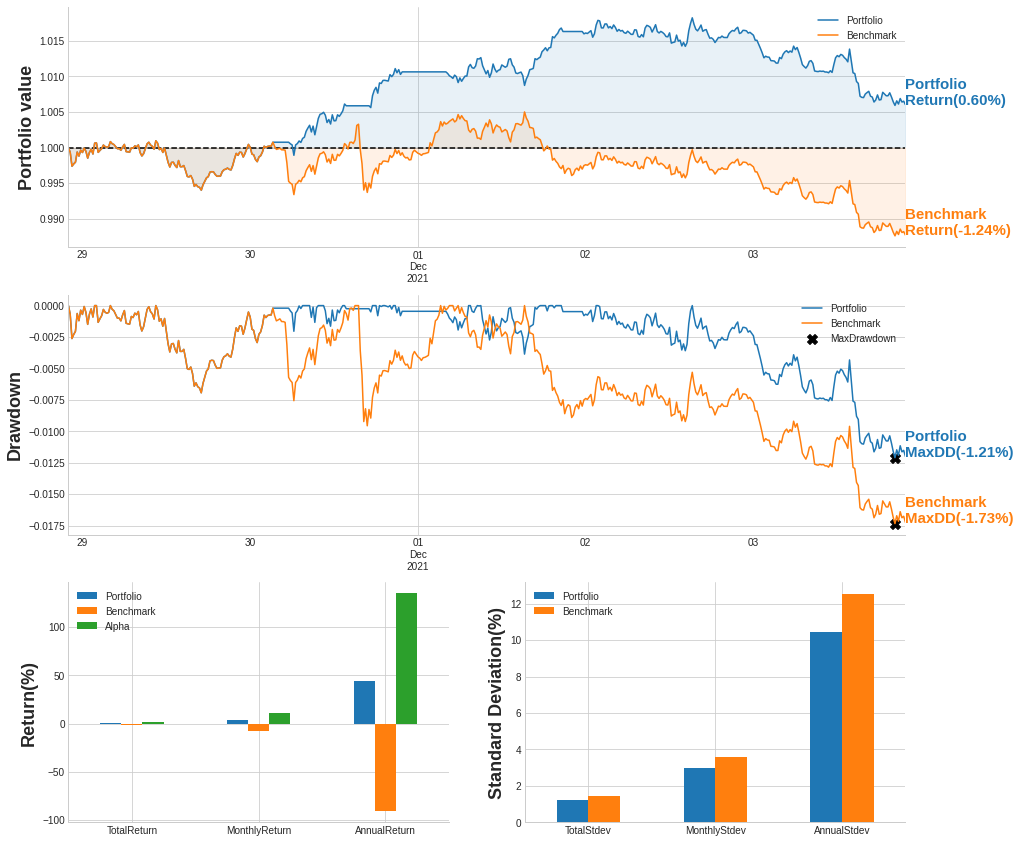

----------------------------------------------------------------------
Data length: |4 days 23:45:00|
Data range from |2021-11-28 22:00:00| to |2021-12-03 21:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       0.601 │      -1.243 │   1.844 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       3.611 │      -7.475 │  11.087 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      43.938 │     -90.949 │ 134.888 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [107]:
print(ticker)
backtest = IterativeBacktester(data=data,
                               signals=data['signal'],
                               freq=freq)
backtest.backtest()
backtest.results()